# **Chapter 4**

In [90]:
import numpy as np
import pandas as pd
import General

import plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'png'

import arviz as az
import pymc as pm
import scipy.stats as stats

az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### **4M1**

For the model definition below, simulate observed $y$ values from the prior (not the posterior).<br>
$y_i ∼ \text{Normal}(\mu, \sigma)$<br>
$\mu ∼ \text{Normal}(0, 10)$<br>
$\sigma ∼ \text{Uniform}(1)$

In [2]:
mu = stats.norm.rvs(loc=0, scale=10, size=10000)
sigma = stats.uniform.rvs(loc=1, scale=10, size=10000)
y = [np.random.normal(mu, sigma, 1) for mu, sigma in zip(mu, sigma)]

### **4M2**

 Translate the model just above into a quap formula.

In [3]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)  # Prior for mu
    sigma = pm.Uniform("sigma", lower=0, upper=1)  # Prior for sigma
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=np.concatenate(y))  # Observed y values

    # Fit the model using MAP (similar to quap)
    posterior = pm.find_MAP()

print("Posterior estimates:")
print(f'mu: {posterior['mu']:.2f}')
print(f'sigma: {posterior['sigma']:.2f}')

Output()

Posterior estimates:
mu: 0.03
sigma: 1.00


### **4M4**

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose.

$h_i ∼ \text{Normal}(\mu, \sigma)$<br>
$\mu ∼ \alpha + \beta (y_i)$<br>
$\alpha ∼ \text{Normal}(0, 100)$<br>
$\beta ∼ \text{Normal}(0, 10)$<br>
$\sigma ∼ \text{Uniform}(50)$

### **4H1**

The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

| **Individual**  | **Weight** | **Expected Height** | **89% Interval**  |
|-----------------|------------|---------------------|-------------------|
| 1               | 46.95      | ?                   | ?                 |
| 2               | 43.72      | ?                   | ?                 |
| 3               | 64.78      | ?                   | ?                 |
| 4               | 32.59      | ?                   | ?                 |
| 5               | 54.63      | ?                   | ?                 |

In [4]:
howell1 = pd.read_csv(r'.\..\Data\Howell1.csv', delimiter=';')
data = howell1[howell1['age'] >= 18]

In [5]:
with pm.Model() as model:
    sigma = pm.Uniform('sigma', 0, 50)
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.Lognormal('beta', mu=0, tau=1)
    mu = alpha + beta*data['weight'].values
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=data['height'].values)

    # Posterior Distribution
    posterior = pm.find_MAP()
    # Hessian Matrix
    Hess = pm.find_hessian(posterior, vars=[alpha, beta, sigma])
    # Extract Samples
    trace = pm.sample(draws=1000, step=pm.Metropolis(), tune=500, progressbar=False)
    
print("\nPosterior estimates:")
print(f'sigma: {posterior['sigma']:.2f}')
print(f'alpha: {posterior['alpha']:.2f}')
print(f'beta: {posterior['beta']:.2f}')

Output()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Posterior estimates:
sigma: 5.07
alpha: 114.53
beta: 0.89


In [6]:
# The inverse of the Hessian matrix is often used to estimate the covariance matrix of the parameters.
# The diagonal elements of the covariance matrix correspond to the variances of the parameters, and the off-diagonal elements correspond to the covariances.
var_cov = np.linalg.inv(Hess)
means = np.fromiter([posterior['alpha'], posterior['beta'], posterior['sigma']], dtype=float)
post_samples = np.random.multivariate_normal(means, var_cov, size=10000)

# Credibility Interval
cred_intervals = np.array(
    [az.hdi(post_samples[:, 0] + post_samples[:, 1] * (x)) for x in np.linspace(20, 70, 100)]
)

# Interval for Real Data
def compute_mu(x):
    return post_samples[:, 0] + post_samples[:, 1] * (x)
pred_intervals = np.array(
    [az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2])) for x in np.linspace(20, 70, 100)]
)

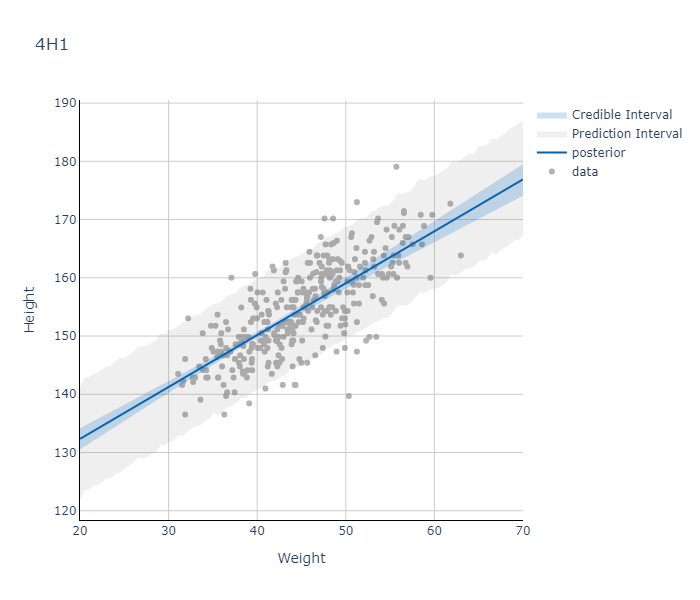

In [7]:
x = np.linspace(20, 70, 100)

fig = go.Figure()

fig.add_trace(trace=go.Scatter(
    x=data['weight'].values, y=data['height'].values,
    mode='markers', marker=dict(color='grey'), opacity=0.6,
    name='data'
))

mu = posterior["alpha"] + posterior["beta"] * (x)
fig.add_trace(trace=go.Scatter(
    x=x, y=mu,
    mode='lines', line=dict(color='#0064b2'),
    name='posterior'
))

fig.add_trace(trace=go.Scatter(
    x=x, y=pred_intervals[:, 0],
    fill=None,
    line=dict(color='rgba(255, 255, 255, 0)'),
    showlegend=False
))
fig.add_trace(trace=go.Scatter(
    x=x, y=pred_intervals[:, 1],
    fill='tonexty', fillcolor='rgba(100, 100, 100, 0.1)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Prediction Interval'
))

fig.add_trace(trace=go.Scatter(
    x=x, y=cred_intervals[:, 0],
    fill=None,
    line=dict(color='rgba(255, 255, 255, 0)'),
    showlegend=False
))
fig.add_trace(trace=go.Scatter(
    x=x, y=cred_intervals[:, 1],
    fill='tonexty', fillcolor='rgba(0, 100, 200, 0.2)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Credible Interval'
))

General.main_layout(fig, title='4H1', x='Weight', y='Height')
fig.show()

In [8]:
# define the data
individuals = np.linspace(1, 5, 5)
weight = np.array([46.95, 43.72, 64.78, 32.59, 54.63])
# compute the mean predictions
means = posterior["alpha"] + posterior["beta"] * weight
# compute the prediction intervals
pred_intervals = np.array(
    [az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2])) for x in weight]
)
data_dict = {
    "Individual": individuals,
    "Weight": weight,
    "Expected height": means,
    "Lower 89% interval": pred_intervals[:, 0],
    "Upper 89% interval": pred_intervals[:, 1],
}
display(pd.DataFrame(data=data_dict))

,Individual,Weight,Expected height,Lower 89% interval,Upper 89% interval
0,1.0,46.95,156.354090,146.312565,165.668748
1,2.0,43.72,153.477031,144.055724,162.959296
2,3.0,64.78,172.235811,162.087751,181.808961
3,4.0,32.59,143.563203,134.432354,153.196298
4,5.0,54.63,163.194898,153.580898,172.699877


### **4H2**

Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

(a) Fit a linear regression to these data, using quap. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.

(c) What aspects of the model fit concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don’t have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

In [91]:
howell1 = pd.read_csv(r'.\..\Data\Howell1.csv', delimiter=';')
data = howell1[howell1['age'] <= 18]

In [92]:
with pm.Model() as model:
    sigma = pm.Uniform('sigma', 0, 50)
    alpha = pm.Normal('alpha', mu=100, sigma=40)
    beta = pm.Lognormal('beta', mu=0, tau=1)
    mu = alpha + beta*data['weight'].values
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=data['height'].values)

    # Posterior Distribution
    posterior = pm.find_MAP()
    # Hessian Matrix
    Hess = pm.find_hessian(posterior, vars=[alpha, beta, sigma])
    
print("\nPosterior estimates:")
print(f'sigma: {posterior['sigma']:.2f}')
print(f'alpha: {posterior['alpha']:.2f}')
print(f'beta: {posterior['beta']:.2f}')

Output()


Posterior estimates:
sigma: 9.06
alpha: 60.93
beta: 2.55


In [93]:
# The inverse of the Hessian matrix is often used to estimate the covariance matrix of the parameters.
# The diagonal elements of the covariance matrix correspond to the variances of the parameters, and the off-diagonal elements correspond to the covariances.
var_cov = np.linalg.inv(Hess)
means = np.fromiter([posterior['alpha'], posterior['beta'], posterior['sigma']], dtype=float)
post_samples = np.random.multivariate_normal(means, var_cov, size=10000)

# Credibility Interval
cred_intervals = np.array(
    [az.hdi(post_samples[:, 0] + post_samples[:, 1] * (x)) for x in np.linspace(0, 50, 100)]
)

# Interval for Real Data
def compute_mu(x):
    return post_samples[:, 0] + post_samples[:, 1] * (x)
pred_intervals = np.array(
    [az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2])) for x in np.linspace(0, 50, 100)]
)

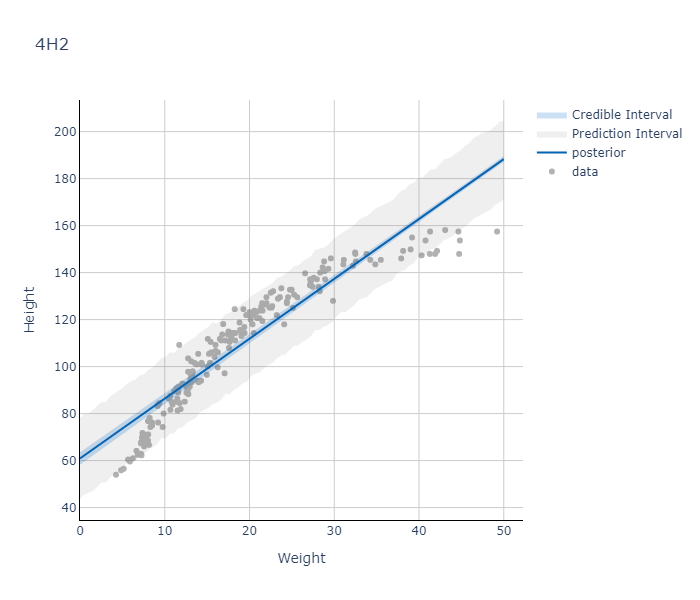

In [94]:
x = np.linspace(0, 50, 100)

fig = go.Figure()

fig.add_trace(trace=go.Scatter(
    x=data['weight'].values, y=data['height'].values,
    mode='markers', marker=dict(color='grey'), opacity=0.6,
    name='data'
))

mu = posterior["alpha"] + posterior["beta"] * (x)
fig.add_trace(trace=go.Scatter(
    x=x, y=mu,
    mode='lines', line=dict(color='#0064b2'),
    name='posterior'
))

fig.add_trace(trace=go.Scatter(
    x=x, y=pred_intervals[:, 0],
    fill=None,
    line=dict(color='rgba(255, 255, 255, 0)'),
    showlegend=False
))
fig.add_trace(trace=go.Scatter(
    x=x, y=pred_intervals[:, 1],
    fill='tonexty', fillcolor='rgba(100, 100, 100, 0.1)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Prediction Interval'
))

fig.add_trace(trace=go.Scatter(
    x=x, y=cred_intervals[:, 0],
    fill=None,
    line=dict(color='rgba(255, 255, 255, 0)'),
    showlegend=False
))
fig.add_trace(trace=go.Scatter(
    x=x, y=cred_intervals[:, 1],
    fill='tonexty', fillcolor='rgba(0, 100, 200, 0.2)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Credible Interval'
))

General.main_layout(fig, title='4H2', x='Weight', y='Height')
fig.show()

### **4H3**

Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens.

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Fit this model, using quadratic approximation:

$h_i ∼ \text{Normal}(\mu, \sigma)$<br>
$\mu ∼ \alpha + \beta \log (y_i)$<br>
$\alpha ∼ \text{Normal}(178, 20)$<br>
$\beta ∼ \text{Lognormal}(0, 1)$<br>
$\sigma ∼ \text{Uniform}(50)$

where $h_i$ is the height of individual i and $w_i$ is the weight (in kg) of individual $i$. The function for computing a natural log. Can you interpret the resulting estimates?
(b) Begin with this plot then use samples from the quadratic approximate posterior of the model in (a) to superimpose on the plot: (1) the predicted mean height as a function of weight, (2) the 97% interval for the mean, and (3) the 97% interval for predicted heights.

In [95]:
howell1 = pd.read_csv(r'.\..\Data\Howell1.csv', delimiter=';')
data = howell1[howell1['age'] <= 18]

In [96]:
with pm.Model() as model:
    sigma = pm.Uniform('sigma', 0, 50)
    alpha = pm.Normal('alpha', mu=138, sigma=20)
    beta = pm.Lognormal('beta', mu=0, tau=1)
    mu = alpha + beta*np.log(data['weight'].values)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=data['height'].values)

    # Posterior Distribution
    posterior = pm.find_MAP()
    # Hessian Matrix
    Hess = pm.find_hessian(posterior, vars=[alpha, beta, sigma])
    
print("\nPosterior estimates:")
print(f'sigma: {posterior['sigma']:.2f}')
print(f'alpha: {posterior['alpha']:.2f}')
print(f'beta: {posterior['beta']:.2f}')

Output()


Posterior estimates:
sigma: 4.66
alpha: -30.32
beta: 49.61


In [97]:
# The inverse of the Hessian matrix is often used to estimate the covariance matrix of the parameters.
# The diagonal elements of the covariance matrix correspond to the variances of the parameters, and the off-diagonal elements correspond to the covariances.
var_cov = np.linalg.inv(Hess)
means = np.fromiter([posterior['alpha'], posterior['beta'], posterior['sigma']], dtype=float)
post_samples = np.random.multivariate_normal(means, var_cov, size=10000)

# Credibility Interval
cred_intervals = np.array(
    [az.hdi(post_samples[:, 0] + post_samples[:, 1] * np.log(x), hdi_prob=0.97) for x in np.linspace(5, 50, 100)]
)

# Interval for Real Data
def compute_mu(x):
    return post_samples[:, 0] + post_samples[:, 1] * np.log(x)
pred_intervals = np.array(
    [az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2]), hdi_prob=0.97) for x in np.linspace(5, 50, 100)]
)

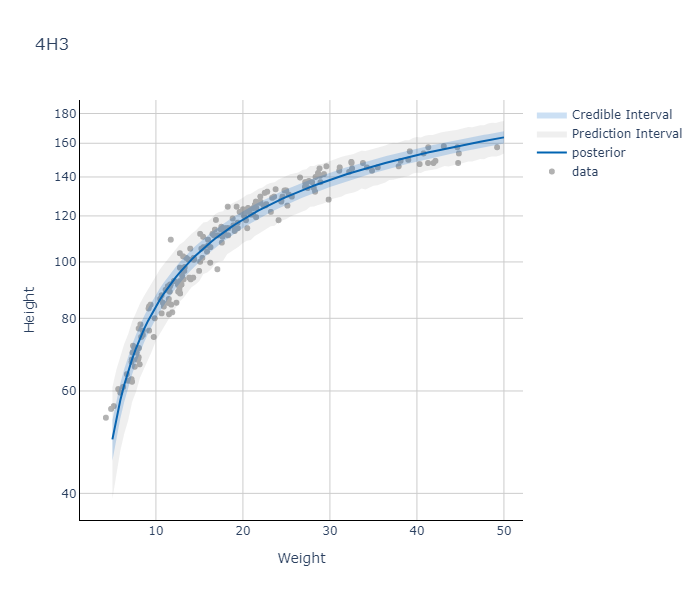

In [98]:
x = np.linspace(5, 50, 100)

fig = go.Figure()

fig.add_trace(trace=go.Scatter(
    x=data['weight'].values, y=data['height'].values,
    mode='markers', marker=dict(color='grey'), opacity=0.6,
    name='data',
))

mu = posterior["alpha"] + posterior["beta"] * np.log(x)
fig.add_trace(trace=go.Scatter(
    x=x, y=mu,
    mode='lines', line=dict(color='#0064b2'),
    name='posterior'
))

fig.add_trace(trace=go.Scatter(
    x=x, y=pred_intervals[:, 0],
    fill=None,
    line=dict(color='rgba(255, 255, 255, 0)'),
    showlegend=False
))
fig.add_trace(trace=go.Scatter(
    x=x, y=pred_intervals[:, 1],
    fill='tonexty', fillcolor='rgba(100, 100, 100, 0.1)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Prediction Interval'
))

fig.add_trace(trace=go.Scatter(
    x=x, y=cred_intervals[:, 0],
    fill=None,
    line=dict(color='rgba(255, 255, 255, 0)'),
    showlegend=False
))
fig.add_trace(trace=go.Scatter(
    x=x, y=cred_intervals[:, 1],
    fill='tonexty', fillcolor='rgba(0, 100, 200, 0.2)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Credible Interval'
))

General.main_layout(fig, title='4H3', x='Weight', y='Height')
fig.update_layout(yaxis={'type':'log'})
fig.show()